In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

# from geopy import distance

import joblib



from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import accuracy_score

import xgboost as xgb





from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [2]:
path = './RCdata'

perfix = '' 
file_name =  '' 

os.chdir(path)

## Load datasets

In [3]:
df = pd.read_csv('selected_data.csv')
df

,general_score_binary,budget,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,other_services,parking_lot,distance_km
0,1,medium,No_Alcohol_Served,not permitted,informal,no_accessibility,medium,familiar,f,none,public,0.693407
1,1,medium,No_Alcohol_Served,section,informal,no_accessibility,medium,familiar,f,none,none,0.806876
2,1,medium,No_Alcohol_Served,none,informal,completely,low,familiar,f,none,none,1.036330
3,1,medium,No_Alcohol_Served,none,informal,no_accessibility,medium,familiar,f,none,none,0.729154
4,1,low,Full_Bar,not permitted,informal,completely,medium,familiar,t,variety,yes,0.080878
...,...,...,...,...,...,...,...,...,...,...,...,...
1156,1,medium,No_Alcohol_Served,none,informal,completely,low,familiar,f,none,none,2.022179
1157,1,medium,No_Alcohol_Served,none,informal,no_accessibility,low,quiet,f,none,none,1.015471
1158,1,low,No_Alcohol_Served,not permitted,informal,completely,medium,familiar,t,none,yes,0.617608
1159,1,low,No_Alcohol_Served,not permitted,informal,completely,low,familiar,f,none,public,0.295448


## Bulding Model

### Label transformation

In [4]:
for col in df.columns:
    if df[col].dtypes == 'object':         
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        
df

,general_score_binary,budget,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,other_services,parking_lot,distance_km
0,1,3,1,1,2,1,2,0,0,1,1,0.693407
1,1,3,1,4,2,1,2,0,0,1,0,0.806876
2,1,3,1,0,2,0,1,0,0,1,0,1.036330
3,1,3,1,0,2,1,2,0,0,1,0,0.729154
4,1,2,0,1,2,0,2,0,1,2,3,0.080878
...,...,...,...,...,...,...,...,...,...,...,...,...
1156,1,3,1,0,2,0,1,0,0,1,0,2.022179
1157,1,3,1,0,2,1,1,1,0,1,0,1.015471
1158,1,2,1,1,2,0,2,0,1,1,3,0.617608
1159,1,2,1,1,2,0,1,0,0,1,1,0.295448


In [5]:
# Splitting the dataset 
X = df.drop(['general_score_binary'], axis = 1)
y = df['general_score_binary']

### Examining Feature Impacts

In [6]:
for col in X.columns:
    scaler = StandardScaler()
    X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))

In [7]:
X

,budget,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,other_services,parking_lot,distance_km
0,0.634757,-0.375035,-0.096263,0.349846,0.417848,0.901177,-0.241539,-0.395442,-0.003585,-0.157777,-0.266312
1,0.634757,-0.375035,1.798001,0.349846,0.417848,0.901177,-0.241539,-0.395442,-0.003585,-0.902407,-0.264921
2,0.634757,-0.375035,-0.727685,0.349846,-1.405916,-0.377878,-0.241539,-0.395442,-0.003585,-0.902407,-0.262108
3,0.634757,-0.375035,-0.727685,0.349846,0.417848,0.901177,-0.241539,-0.395442,-0.003585,-0.902407,-0.265874
4,-0.579333,-2.196858,-0.096263,0.349846,-1.405916,0.901177,-0.241539,2.528815,4.159176,1.331483,-0.273821
...,...,...,...,...,...,...,...,...,...,...,...
1156,0.634757,-0.375035,-0.727685,0.349846,-1.405916,-0.377878,-0.241539,-0.395442,-0.003585,-0.902407,-0.250023
1157,0.634757,-0.375035,-0.727685,0.349846,0.417848,-0.377878,4.140124,-0.395442,-0.003585,-0.902407,-0.262364
1158,-0.579333,-0.375035,-0.096263,0.349846,-1.405916,0.901177,-0.241539,2.528815,-0.003585,1.331483,-0.267241
1159,-0.579333,-0.375035,-0.096263,0.349846,-1.405916,-0.377878,-0.241539,-0.395442,-0.003585,-0.157777,-0.271190


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)
print("X_train shape:", X_train.shape) 
print("X_test shape:", X_test.shape) 
print("Y_train shape:", Y_train.shape) 
print("Y_test shape:", Y_test.shape)

X_train shape: (812, 11)
X_test shape: (349, 11)
Y_train shape: (812,)
Y_test shape: (349,)


## XG Boost Model

In [9]:
xgbr= xgb.XGBClassifier(base_score=0.5, learning_rate=0.1, max_depth=5,
       n_estimators=200, n_jobs=42, gpu_id=0, random_state=101,
       objective='binary:logistic', alpha=10)



# XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1, 
#                        max_depth = 15, alpha = 10, n_estimators = 220, n_jobs=42, gpu_id=0, random_state=101)

In [10]:
xgbr.fit(X_train, Y_train)

/home/adminux/anaconda3/envs/webscrap/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:41:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=42,
              num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
Y_pred_xgbr = xgbr.predict(X_test)

In [12]:
# make predictions for test data

predictions = [round(value) for value in Y_pred_xgbr]
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)

print('XG Boost Classifier:') 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XG Boost Classifier:
Accuracy: 79.66%


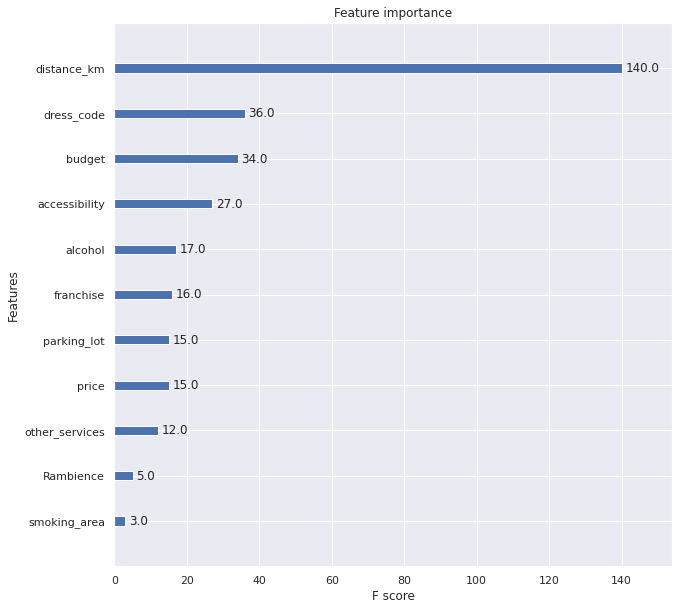

In [14]:
sns.set_theme()
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

#### Above results demonstrate that 'smoking_area' and 'Rambiance' are not highly effective features for salary perdiction. But still, I prefer to keeo it in the dataset. On the other hand engineered feature of 'distance_km' is highly effective.